In [1]:
import sys
sys.path.append('code/BalancingControl')

import recovery_utils as ru
import inference as inf

torch threads 1
Running on device cpu


In [2]:
import torch
import pyro

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
import json
import gc

In [3]:
results_folder = "results"
inference_folder = os.path.join(results_folder, "inference")
model_comp_folder = os.path.join(results_folder, "model_comparison")

mask_file_name = "mask.txt"
processed_data_folder = os.path.join(results_folder, "processed_data")
mask_file = os.path.join(processed_data_folder, mask_file_name)

processed_data_folder = os.path.join(results_folder, "processed_data")

non_fit_fname = "non_fit_file.txt"
non_fit_file = os.path.join(model_comp_folder, non_fit_fname)

full_data_fname = "full_data.csv"
full_data_file = os.path.join(processed_data_folder, full_data_fname)

full_data_df = pd.read_csv(full_data_file)

n_agents = 188

In [4]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
# prob for invalid answer (e.g. no reply). Same frequency as in the real data
with open(mask_file, "rb") as f:
    all_mask = pickle.load(f)
# simulations will be done with the same missing actions as in the data.
exp_mask = torch.tensor(all_mask).permute((1,0))
p_valid = exp_mask.sum()/(exp_mask.shape[0]*exp_mask.shape[1])
print(p_valid)

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid, "mask": exp_mask}

tensor(0.9766)


/tmp/ipykernel_11862/1548601007.py:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  exp_mask = torch.tensor(all_mask).permute((1,0))


In [5]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

In [6]:
def convert_data_for_agent(full_data_df):

    mask = full_data_df.loc[(full_data_df["step_index"]==1)]
    mask_formatted = torch.stack([torch.from_numpy(mask.loc[mask["subject"]==i]["mask"].to_numpy()) for i in range(n_agents)])

    actions1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    actions1_formatted = torch.stack([torch.from_numpy(actions1.loc[actions1["subject"]==i]["first_stage_actions"].to_numpy()) for i in range(n_agents)])

    actions2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    actions2_formatted = torch.stack([torch.from_numpy(actions2.loc[actions2["subject"]==i]["second_stage_actions"].to_numpy()) for i in range(n_agents)])

    print("possible actions1", torch.unique(actions1_formatted[mask_formatted]))
    print("possible actions2", torch.unique(actions2_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    actions1_formatted = torch.where(mask_formatted, actions1_formatted, -1)
    actions2_formatted = torch.where(mask_formatted, actions2_formatted, -1)

    actions = torch.stack([actions1_formatted, actions2_formatted], dim=-1).permute((1,2,0))
    #print(actions.permute((0,2,1))[mask_formatted])
    # agent counts from zero:
    actions = actions-1.

    states1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    # agent counts from zero, hence -1 at the end:
    states1_formatted = torch.stack([torch.from_numpy(states1.loc[states1["subject"]==i]["first_stage_states"].to_numpy()) for i in range(n_agents)]) - 1
     
    states2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    # agent counts from zero, hence -1 at the end:
    states2_formatted = torch.stack([torch.from_numpy(states2.loc[states2["subject"]==i]["second_stage_states"].to_numpy()) for i in range(n_agents)]) - 1

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    states1_formatted = torch.where(mask_formatted, states1_formatted, -1)
    states2_formatted = torch.where(mask_formatted, states2_formatted, -1)
    # create third time step states:
    states3_formatted = states2_formatted+2 + (actions2_formatted-1)*2
    states3_formatted = torch.where(mask_formatted, states3_formatted, -1)


    print("possible states1", torch.unique(states1_formatted[mask_formatted]))
    print("possible states2", torch.unique(states2_formatted[mask_formatted]))
    print("possible states3", torch.unique(states3_formatted[mask_formatted]))

    states = torch.stack([states1_formatted, states2_formatted, states3_formatted], dim=-1).permute((1,2,0))

    # agent views r=2 as "no reward", may instead give negative reward as in Otto et al:
    rewards1_formatted = torch.zeros_like(states1_formatted) #+ 2

    rewards2_formatted = rewards1_formatted

    # create third time step rewards = second stage rewards:
    rewards3 = full_data_df.loc[(full_data_df["step_index"]==2)]
    rewards3_formatted = torch.stack([torch.from_numpy(rewards3.loc[rewards3["subject"]==i]["second_stage_rewards"].to_numpy()) for i in range(n_agents)])

    print("possible rewards1", torch.unique(rewards1_formatted[mask_formatted]))
    print("possible rewards2", torch.unique(rewards2_formatted[mask_formatted]))
    print("possible rewards3", torch.unique(rewards3_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    rewards1_formatted = torch.where(mask_formatted, rewards1_formatted, -1)
    rewards2_formatted = torch.where(mask_formatted, rewards2_formatted, -1)
    rewards3_formatted = torch.where(mask_formatted, rewards3_formatted, -1)

    rewards = torch.stack([rewards1_formatted, rewards2_formatted, rewards3_formatted], dim=-1).permute((1,2,0))


    data_dict = {"observations": states.long(), "rewards": rewards.long(), "actions": actions.long(), "valid": mask_formatted.permute((1,0))}

    return data_dict

data = convert_data_for_agent(full_data_df)

possible actions1 tensor([1., 2.], dtype=torch.float64)
possible actions2 tensor([1., 2.], dtype=torch.float64)
possible states1 tensor([0.], dtype=torch.float64)
possible states2 tensor([1., 2.], dtype=torch.float64)
possible states3 tensor([3., 4., 5., 6.], dtype=torch.float64)
possible rewards1 tensor([0.], dtype=torch.float64)
possible rewards2 tensor([0.], dtype=torch.float64)
possible rewards3 tensor([0., 1.], dtype=torch.float64)


In [7]:
def load_BCC_results(infer_h, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    bayes_agent = ru.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_sample_df = ru.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_sample_df = ru.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_sample_df

In [8]:
def load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    mfmb_agent = ru.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(mfmb_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_sample_df = ru.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_sample_df = ru.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_sample_df

In [9]:
def calculate_log_likelihood_mean_param(data, agent, locs_df, npars, trials, T):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # this is the likelihood of the average parameter
    # answer: multiply the log by 0

    n_agents = data["actions"].shape[-1]

    log_like = []
    
    # print("locs df 0", locs_df["locs"+str(0)].shape)
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    # print("resulting locs", locs.shape)
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                test = probs > 1
                if test.sum()>0:
                    print(probs)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]
                test = likes > 1
                if test.sum()>0:
                    print(likes)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))

                test = masked_probs > 1
                if test.sum()>0:
                    print("masked", masked_probs)

                log_like.append(torch.log(masked_probs))#*data["valid"][tau].long())

                test = torch.exp(log_like[-1]) > 1
                if test.sum()>0:
                    print("log like", torch.exp(log_like[-1]))


    log_like = torch.stack(log_like, dim=0)

    test = torch.exp(log_like) > 1
    if test.sum()>0:
        print("total")

    return log_like
    

In [10]:
def calculate_lppd(data, agent, locs_df, npars, trials, T, max_samples=-1):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # Eqs (4,5) from here:
    # http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    # this is the average likelihood
    
    n_agents = data["actions"].shape[-1]
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(torch.tensor(locs_df[locs_df["subject"]==i]["locs"+str(k)].values[:max_samples]).float())
        locs_list.append(torch.stack(locs_subs, dim=-1))

    locs = torch.stack(locs_list, dim=-1)
    print("lppd locs", locs.shape)
    
    assert(locs.shape[1]==n_agents)

    #locs = torch.stack([torch.tensor(locs_df["locs"+str(i)]) for i in range(npars)], dim=-1).float()[:max_samples]

    #print("locs", locs.shape)

    n_samples = locs.shape[0]

    likelihoods = []

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                #print("probs", probs.shape)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))
                #print("masked probs", masked_probs.shape)

                likelihoods.append(masked_probs)

                #print(tau,t)

    mean_like = torch.stack(likelihoods, dim=0)
    # print("mean like stacked", mean_like.shape)
    # print(mean_like)

    mean_like = mean_like.sum(dim=-2) / n_samples
    # print("mean like summed", mean_like.shape)
    # print(mean_like)

    mean_log_like = torch.log(mean_like)#.sum(dim=0)

    #print(mean_log_like)
    # print("mean log like", mean_log_like.shape)
    # print(mean_log_like)

    return mean_log_like
    

In [11]:
def predictive_accuracy_mean_param(data, agent, locs_df, npars, trials, T):

    n_agents = data["actions"].shape[-1]

    predicted_accuracy = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    num_valid_responses = torch.zeros(data["actions"].shape[-1])

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:
                #print(tau,t)

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]#*data["valid"][tau].long()
                #print(curr_response)

                predicted_response = torch.argmax(probs, dim=0)[0]

                #print(probs)

                #print(predicted_response)

                correct_response_predicted = (curr_response == predicted_response).int()

                #print(correct_response_predicted)

                predicted_accuracy += correct_response_predicted

                num_valid_responses += data["valid"][tau]

                #print(num_valid_responses)


    corrected_predicted_accuracy = predicted_accuracy / num_valid_responses

    return corrected_predicted_accuracy

In [12]:
def calculate_avg_likelihood_mean_param(data, agent, locs_df, npars, trials, T):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # this is the likelihood of the average parameter
    
    n_agents = data["actions"].shape[-1]

    like = torch.zeros(n_agents)
    log_like = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    num_valid_responses = torch.zeros(data["actions"].shape[-1])

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.0]))

                like += masked_probs*data["valid"][tau]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))

                log_like += torch.log(masked_probs)*data["valid"][tau]

                num_valid_responses += data["valid"][tau]

    avg_like = like / num_valid_responses
    avg_log_like = log_like / num_valid_responses
    avg_like_from_log = torch.exp(avg_log_like)

    return avg_like, avg_like_from_log
    

BCC_3param_inference_
analyzing 188 data sets
     Unnamed: 0  inferred policy rate  subject  inferred reward rate  \
0             0              0.681962        0              0.162679   
1             1              0.511521        1              0.182651   
2             2              0.571729        2              0.278356   
3             3              0.146759        3              0.035538   
4             4              0.498179        4              0.380612   
..          ...                   ...      ...                   ...   
183         183              0.712550      183              0.447246   
184         184              0.664887      184              0.307476   
185         185              0.642970      185              0.269673   
186         186              0.571043      186              0.243605   
187         187              0.707865      187              0.709979   

     inferred dec temp  
0             7.506910  
1             7.423363  
2             

/home/sarah/src/BayesianTwoStageTaskAnalysis/code/BalancingControl/perception.py:107: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699116133598/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


<Figure size 640x480 with 0 Axes>

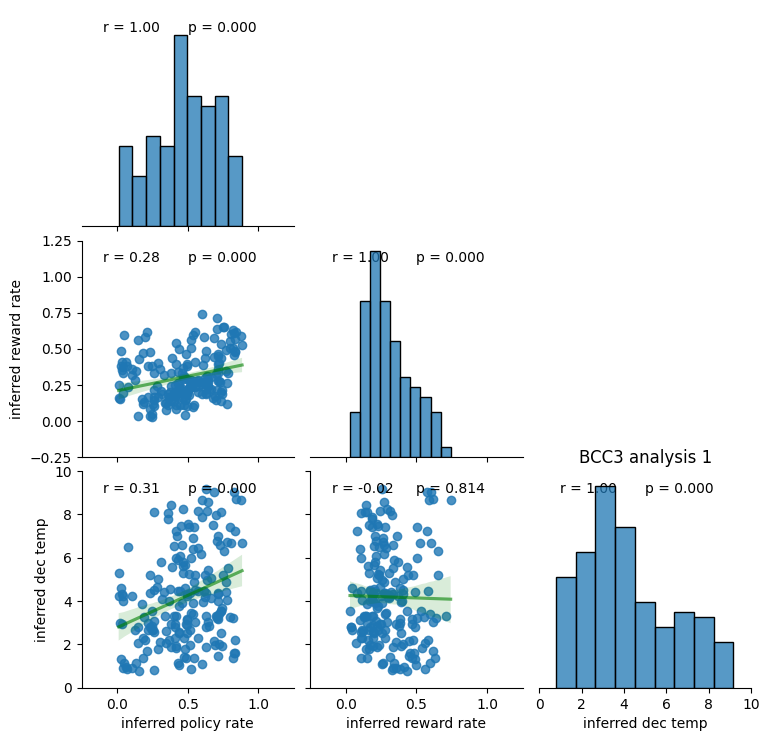

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC_3param) with 188 agents.
The settings are: infer h False


In [13]:
# BCC3 analysis 1

infer_h = False

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC3_param_names = param_names

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC3_1_mean_df, BCC3_1_sample_df, BCC3_1_locs_df = load_BCC_results(infer_h, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names)

BCC3_agent = ru.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

print(BCC3_1_mean_df)
print(BCC3_1_sample_df)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC3_1_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(ru.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)

In [14]:
BCC3_log_like = -calculate_log_likelihood_mean_param(data, BCC3_agent, BCC3_1_locs_df, len(BCC3_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC3_lppd = -calculate_lppd(data, BCC3_agent, BCC3_1_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

lppd locs torch.Size([50, 188, 3])


39 participants have random behavior under the model (p>0.01)


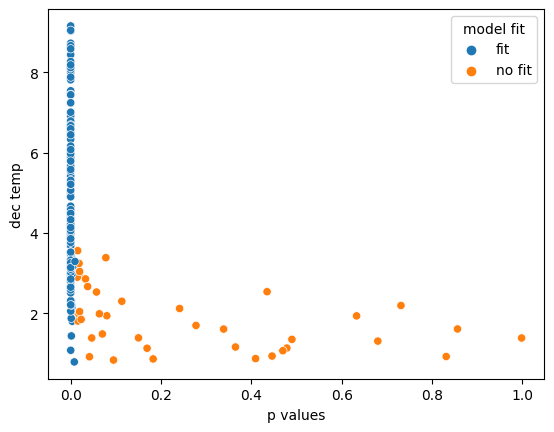

[7, 24, 26, 34, 41, 44, 51, 69, 75, 82, 84, 89, 92, 100, 106, 108, 114, 115, 117, 119, 120, 123, 128, 135, 143, 144, 145, 152, 155, 157, 162, 164, 167, 170, 174, 175, 176, 181, 183]


In [15]:
from scipy.stats import ttest_1samp
from scipy.stats import pearsonr

ttest_results = []
BCC3_didnt_fit = []
p_values = []
didnt_fit_str = []

null_hypothesis = -torch.log(torch.tensor(0.5))
significance_level = 0.05

for n in range(n_agents):
    ttest_results.append(ttest_1samp(BCC3_log_like[:,n], null_hypothesis))
    p_values.append(ttest_results[-1].pvalue)
    #print(ttest_results[-1])
    if ttest_results[-1].pvalue > significance_level:
        #print(n)
        #print(ttest_results[-1])
        BCC3_didnt_fit.append(n)
        didnt_fit_str.append("no fit")
    else:
        didnt_fit_str.append("fit")

p_values = torch.tensor(p_values)

print(len(BCC3_didnt_fit), "participants have random behavior under the model (p>"+str(significance_level)+")")

plot_df_corr_p_val_dec_temp = pd.DataFrame({"p values": p_values, "model fit": didnt_fit_str,
                                            "dec temp": BCC3_1_mean_df["inferred dec temp"],
                                            "subject": list(range(n_agents))})
plt.figure()
sns.scatterplot(data=plot_df_corr_p_val_dec_temp, x="p values", y="dec temp", hue="model fit")#, style="model fit", hue="subject")
plt.show()
#pearsonr(p_values, BCC3_1_mean_df["inferred dec temp"])

print(BCC3_didnt_fit)


BCC_4param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

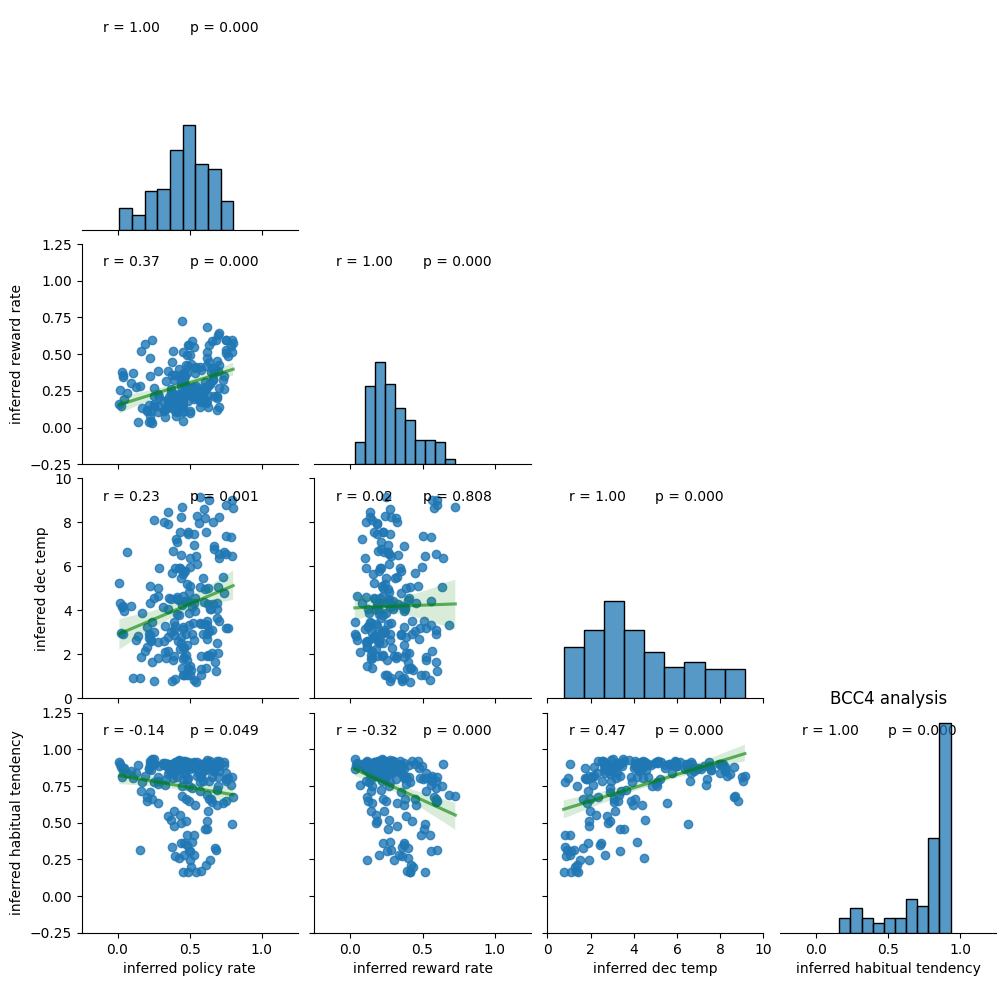

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC_4param) with 188 agents.
The settings are: infer h True


In [16]:
# BCC4

infer_h = True

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC4_param_names = param_names

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC4_mean_df, BCC4_sample_df, BCC4_locs_df = load_BCC_results(infer_h, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names)

BCC4_agent = ru.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

BCC_param_ranges = [[0,1], [0,1], [0,max_dt], [0,1]]
BCC_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10], [-0.25,1.25]]
BCC_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(ru.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)

In [17]:
BCC4_log_like = -calculate_log_likelihood_mean_param(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC4_lppd = -calculate_lppd(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

lppd locs torch.Size([50, 188, 4])


27 participants have random behavior under the model (p>0.01)


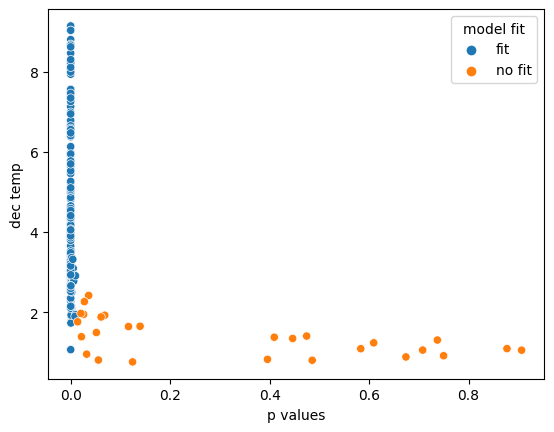

[7, 26, 34, 51, 82, 84, 89, 92, 100, 106, 108, 119, 123, 129, 143, 144, 145, 152, 155, 157, 167, 170, 174, 175, 176, 181, 183]


In [18]:
from scipy.stats import ttest_1samp
from scipy.stats import pearsonr

ttest_results = []
BCC4_didnt_fit = []
p_values = []
didnt_fit_str = []

for n in range(n_agents):
    ttest_results.append(ttest_1samp(BCC4_log_like[:,n], null_hypothesis))
    p_values.append(ttest_results[-1].pvalue)
    #print(ttest_results[-1])
    if ttest_results[-1].pvalue > significance_level:
        #print(n)
        #print(ttest_results[-1])
        BCC4_didnt_fit.append(n)
        didnt_fit_str.append("no fit")
    else:
        didnt_fit_str.append("fit")

p_values = torch.tensor(p_values)

print(len(BCC4_didnt_fit), "participants have random behavior under the model (p>"+str(significance_level)+")")

plot_df_corr_p_val_dec_temp = pd.DataFrame({"p values": p_values, "model fit": didnt_fit_str,
                                            "dec temp": BCC4_mean_df["inferred dec temp"],
                                            "subject": list(range(n_agents))})
plt.figure()
sns.scatterplot(data=plot_df_corr_p_val_dec_temp, x="p values", y="dec temp", hue="model fit")#, style="model fit", hue="subject")
plt.show()
#pearsonr(p_values, BCC3_1_mean_df["inferred dec temp"])

print(BCC4_didnt_fit)


mbmf_4param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

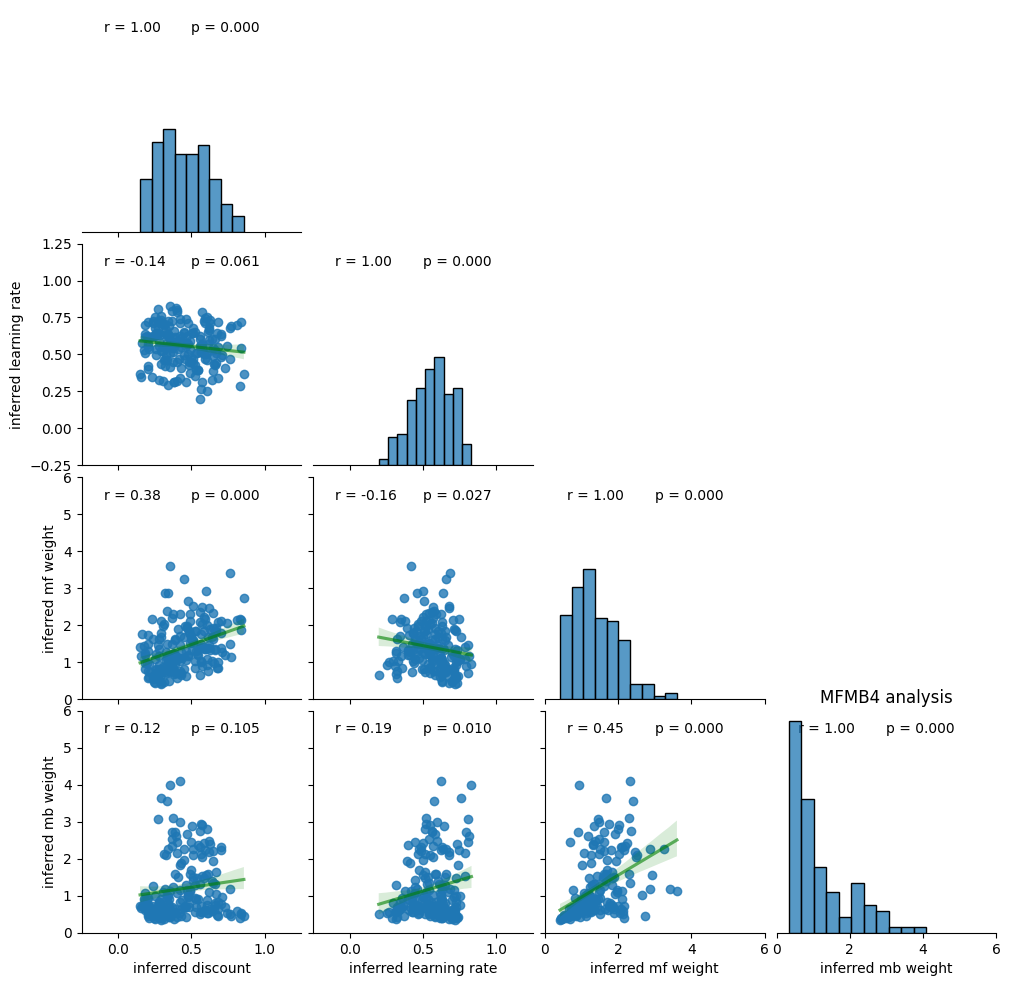

This is inference for the twostage task using the two beta mbmf model(mbmf_4param) with 188 agents.
The settings are: use p False


In [19]:
# MFMB4 analysis

# set parameters and their names

use_orig = False

use_p = False
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB4_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB4_mean_df, MFMB4_sample_df, MFMB4_locs_df = load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, param_names)

MFMB4_agent = ru.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(ru.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

In [20]:
MFMB4_log_like = -calculate_log_likelihood_mean_param(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB4_lppd = -calculate_lppd(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

lppd locs torch.Size([50, 188, 4])


30 participants have random behavior under the model (p>0.01)
Index(['Unnamed: 0', 'inferred discount', 'subject', 'inferred learning rate',
       'inferred mf weight', 'inferred mb weight'],
      dtype='object')


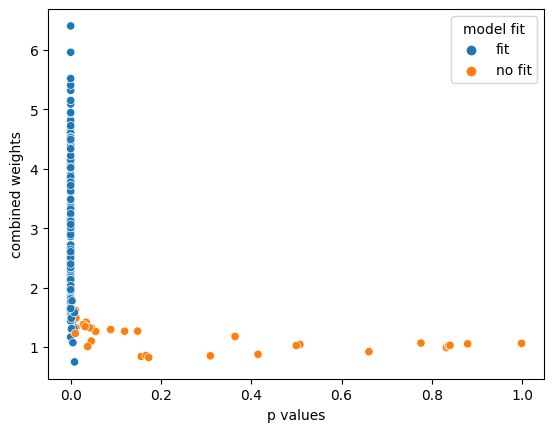

[7, 26, 34, 41, 51, 82, 84, 89, 92, 100, 106, 108, 114, 115, 119, 120, 123, 128, 143, 144, 145, 152, 155, 157, 164, 167, 170, 175, 181, 183]


In [21]:
from scipy.stats import ttest_1samp
from scipy.stats import pearsonr

ttest_results = []
MFMB4_didnt_fit = []
p_values = []
didnt_fit_str = []

null_hypothesis = -torch.log(torch.tensor(0.5))
for n in range(n_agents):
    ttest_results.append(ttest_1samp(MFMB4_log_like[:,n], null_hypothesis))
    p_values.append(ttest_results[-1].pvalue)
    #print(ttest_results[-1])
    if ttest_results[-1].pvalue > significance_level:
        #print(n)
        #print(ttest_results[-1])
        MFMB4_didnt_fit.append(n)
        didnt_fit_str.append("no fit")
    else:
        didnt_fit_str.append("fit")

p_values = torch.tensor(p_values)

print(len(MFMB4_didnt_fit), "participants have random behavior under the model (p>"+str(significance_level)+")")

print(MFMB4_mean_df.keys())
plot_df_corr_p_val_dec_temp = pd.DataFrame({"p values": p_values, "model fit": didnt_fit_str,
                                            "combined weights": MFMB4_mean_df["inferred mf weight"]+MFMB4_mean_df["inferred mb weight"],
                                            "subject": list(range(n_agents))})
plt.figure()
sns.scatterplot(data=plot_df_corr_p_val_dec_temp, x="p values", y="combined weights", hue="model fit")#, style="model fit", hue="subject")
plt.show()
#pearsonr(p_values, BCC3_1_mean_df["inferred dec temp"])


print(MFMB4_didnt_fit)

mbmf_5param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

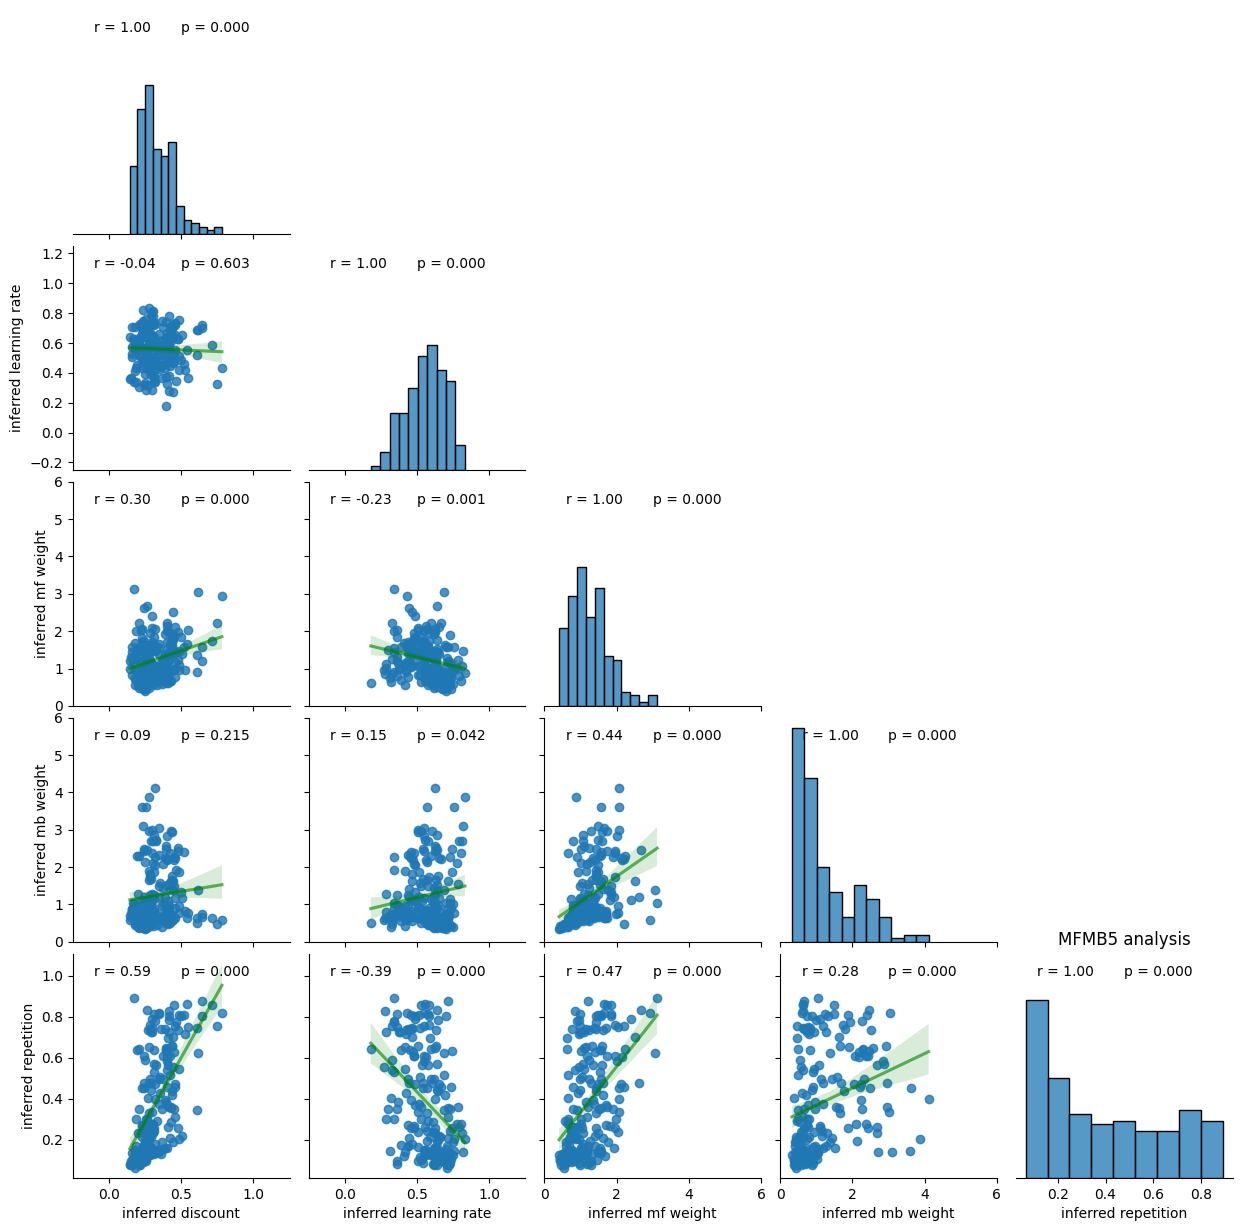

This is inference for the twostage task using the two beta mbmf model(mbmf_5param) with 188 agents.
The settings are: use p True


In [22]:
# MFMB5 analysis

# set parameters and their names

use_orig = False

use_p = True
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB5_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB5_mean_df, MFMB5_sample_df, MFMB5_locs_df = load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, param_names)

MFMB5_agent = ru.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(ru.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

In [23]:
MFMB5_log_like = -calculate_log_likelihood_mean_param(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB5_lppd = -calculate_lppd(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

lppd locs torch.Size([50, 188, 5])


31 participants have random behavior under the model (p>0.01)
Index(['Unnamed: 0', 'inferred discount', 'subject', 'inferred learning rate',
       'inferred mf weight', 'inferred mb weight', 'inferred repetition'],
      dtype='object')


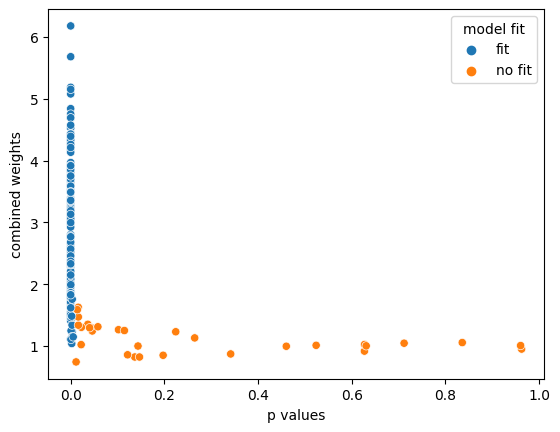

[7, 26, 34, 41, 51, 82, 84, 89, 92, 100, 106, 108, 114, 115, 119, 120, 123, 128, 129, 143, 144, 145, 152, 155, 157, 164, 167, 170, 175, 176, 183]


In [24]:
from scipy.stats import ttest_1samp
from scipy.stats import pearsonr

ttest_results = []
MFMB5_didnt_fit = []
didnt_fit_str = []
p_values = []

null_hypothesis = -torch.log(torch.tensor(0.5))
for n in range(n_agents):
    ttest_results.append(ttest_1samp(MFMB5_log_like[:,n], null_hypothesis))
    p_values.append(ttest_results[-1].pvalue)
    #print(ttest_results[-1])
    if ttest_results[-1].pvalue > significance_level:
        #print(n)
        #print(ttest_results[-1])
        MFMB5_didnt_fit.append(n)
        didnt_fit_str.append("no fit")
    else:
        didnt_fit_str.append("fit")

p_values = torch.tensor(p_values)

print(len(MFMB5_didnt_fit), "participants have random behavior under the model (p>"+str(significance_level)+")")

print(MFMB5_mean_df.keys())
plot_df_corr_p_val_dec_temp = pd.DataFrame({"p values": p_values, "model fit": didnt_fit_str,
                                            "combined weights": MFMB5_mean_df["inferred mf weight"]+MFMB5_mean_df["inferred mb weight"],
                                            "subject": list(range(n_agents))})
plt.figure()
sns.scatterplot(data=plot_df_corr_p_val_dec_temp, x="p values", y="combined weights", hue="model fit")#, style="model fit", hue="subject")
plt.show()
#pearsonr(p_values, BCC3_1_mean_df["inferred dec temp"])

print(MFMB5_didnt_fit)


In [25]:
# which participants dont fit in all models?

BCC_didnt_fit = list(set(BCC3_didnt_fit) & set(BCC4_didnt_fit))

MFMB_didnt_fit = list(set(MFMB4_didnt_fit) & set(MFMB5_didnt_fit))

all_didnt_fit = list(set(BCC_didnt_fit) & set(MFMB_didnt_fit))

print(len(all_didnt_fit), "didnt fit in all the models:")
print(all_didnt_fit)

with open(non_fit_file, "w") as f:
    json.dump(all_didnt_fit, f)

23 didnt fit in all the models:
[7, 143, 144, 145, 152, 26, 155, 157, 34, 167, 170, 175, 51, 183, 82, 84, 89, 92, 100, 106, 108, 119, 123]


In [26]:
BCC3_1_sample_df.groupby("subject").std().mean()

Unnamed: 0     27162.584560
policy rate        0.124784
reward rate        0.068028
dec temp           0.607955
dtype: float64

In [27]:
BCC4_sample_df.groupby("subject").std().mean()

Unnamed: 0           27162.584560
policy rate              0.134094
reward rate              0.066467
dec temp                 0.608430
habitual tendency        0.137629
dtype: float64

In [28]:
MFMB4_sample_df.groupby("subject").std().mean()

Unnamed: 0       27162.584560
discount             0.128532
learning rate        0.099744
mf weight            0.502307
mb weight            0.368111
dtype: float64

In [29]:
MFMB5_sample_df.groupby("subject").std().mean()

Unnamed: 0       27162.584560
discount             0.129060
learning rate        0.104968
mf weight            0.509208
mb weight            0.379470
repetition           0.146294
dtype: float64

In [30]:
test = torch.exp(-BCC3_log_like) > 1

print(test.sum())

tensor(0)


tensor(0.9996)


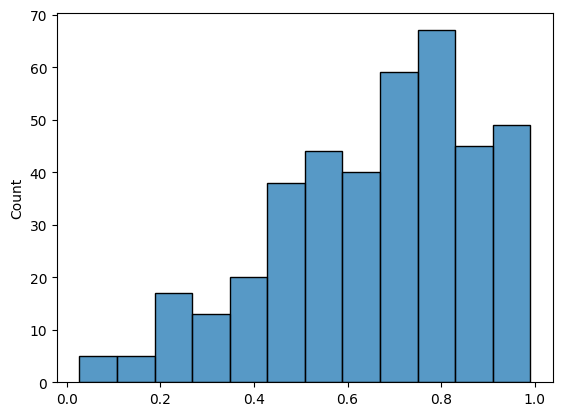

In [31]:
#print(BCC3_log_like[...,0])
BCC3_like = torch.exp(-BCC3_log_like)
print(BCC3_like.amax())

plt.figure()
sns.histplot(BCC3_like[...,6])
plt.show()

tensor(1.0000)


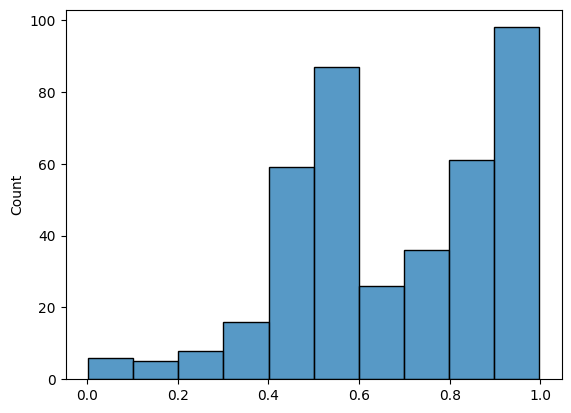

In [32]:
MFMB4_like = torch.exp(-MFMB4_log_like)
print(MFMB4_like.amax())

plt.figure()
sns.histplot(MFMB4_like[...,6])
plt.show()

In [33]:
BCC3_total_log_like = BCC3_log_like.sum(dim=0)
BCC4_total_log_like = BCC4_log_like.sum(dim=0)

MFMB4_total_log_like = MFMB4_log_like.sum(dim=0)
MFMB5_total_log_like = MFMB5_log_like.sum(dim=0)

all_total_log_likes = torch.stack([BCC3_total_log_like, BCC4_total_log_like, MFMB4_total_log_like, MFMB5_total_log_like], dim=-1)

winning_model = all_total_log_likes.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())


BCC3 wins tensor(21)
BCC4 wins tensor(53)
MFMB4 wins tensor(28)
MFMB5 wins tensor(86)


In [34]:
all_total_log_likes = torch.stack([MFMB4_total_log_like, MFMB5_total_log_like, BCC3_total_log_like, BCC4_total_log_like], dim=-1)

winning_model = all_total_log_likes.argmin(dim=-1)

print("BCC3 wins", (winning_model==2).sum())
print("BCC4 wins", (winning_model==3).sum())
print("MFMB4 wins", (winning_model==0).sum())
print("MFMB5 wins", (winning_model==1).sum())

BCC3 wins tensor(21)
BCC4 wins tensor(53)
MFMB4 wins tensor(28)
MFMB5 wins tensor(86)


In [35]:
delta_BCC3 = BCC3_total_log_like[...,None] - torch.stack([BCC4_total_log_like, MFMB4_total_log_like, MFMB5_total_log_like], dim=-1)

print(delta_BCC3)

tensor([[-4.2764e-01, -1.5099e+01, -1.3113e+01],
        [-6.7145e-01,  1.5053e+01,  1.7067e+01],
        [ 6.4163e-02, -8.3305e+00, -7.5755e+00],
        [-9.8605e-01,  1.2226e+01,  1.6700e+01],
        [-4.2235e-01,  1.3801e+01,  1.8142e+01],
        [-3.3357e-01,  2.9302e+01,  3.0570e+01],
        [-5.9622e-01,  8.0139e+00,  1.0157e+01],
        [ 6.1060e+00,  7.4107e+00,  7.2236e+00],
        [-5.1701e-01, -2.9250e-01,  5.0909e+00],
        [-2.2086e-01,  2.8071e+00,  3.6546e+00],
        [-5.5643e-01,  1.9962e+00,  4.6991e+00],
        [-5.1477e-01,  9.1530e+00,  1.2337e+01],
        [-9.6100e-02, -1.7253e+01, -1.5537e+01],
        [-6.2547e-01,  4.9406e+00,  9.9068e+00],
        [-5.5437e-01,  1.1717e+01,  1.3049e+01],
        [-4.2693e-01,  4.8539e+00,  4.3466e+00],
        [-8.0399e-01,  9.1694e+00,  1.1683e+01],
        [ 5.2164e-01, -4.2661e+00, -1.1474e+00],
        [-8.3612e-01,  2.5678e+01,  2.7203e+01],
        [ 7.7286e-02,  3.1141e+00,  2.5191e+00],
        [ 8.8466e-01